In [1]:
!pip install -r /kaggle/input/requirements-file/bd_requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 63.0 MB/s eta 0:00:00
  Obtaining dependency information for geopandas==0.13.2 from https://files.pythonhosted.org/packages/cb/7b/2fb6ab376c78d2e60812ad0bf4b24889309d2aeb543f54efcd586c69907f/geopandas-0.13.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 66.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 88.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 55.8 MB/s eta 0:00:00
  Obtaining dependency information for segmentation-models-pytorch==0.3.3 from https://files.pythonhosted.org/packages/cb/70/4aac1b240b399b108ce58029ae54bc14497e1bbc275dfab8fd3c84c1e35d/segmentation_models_pytorch-0.3.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.8/115.8 k

## Ensure to restart your kernel

In [2]:
import numpy as np
print(np.__version__)

1.24.3


# IMPORTING LIBRARIES

In [3]:
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import random
import math
import cv2
from tqdm.notebook import tqdm
from skimage import io, transform
import rasterio as rio
from rasterio import features
from pathlib import Path
import pathlib
import geopandas as gpd
from PIL import Image
import xarray as xr
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from collections import defaultdict
import torch
import torch.optim as optim
from torch import nn
from torch.optim import lr_scheduler
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Sampler, BatchSampler
from transformers import get_cosine_schedule_with_warmup
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# GETTING FILE PATHS

In [4]:
def combine_files(image_path, label_path):
    files = {'image': image_path, 'mask': label_path}
    return files

def get_files(base_dir):
    subfolders = sorted(glob.glob(os.path.join(base_dir, '*')))
    files_list = []

    for subfolder in subfolders:
        images = sorted(glob.glob(os.path.join(subfolder, "images/*")))
        labels = sorted(glob.glob(os.path.join(subfolder, "labels_match/*")))
        
        # Assuming the number of images and labels is the same for each subfolder
        for image_path, label_path in zip(images, labels):
            files_list.append(combine_files(image_path, label_path))

    return files_list

In [5]:
# Example usage
base_directory = "/kaggle/input/spacenet-7-multitemporal-urban-development/SN7_buildings_train/train"
files = get_files(base_directory)
print(len(files))
files = random.sample(files, 200)
print(len(files))
# print(files[0])

1423
200


# SETTING UP DATALOADER

In [6]:
class SpaceNet7(Dataset):
    def __init__(self, files, tile_size, transforms_=None):
        self.files = files
        self.tile_size = tile_size
        self.transforms_ = transforms_

    def rasterize_geojson(self, idx):
        # Read the GeoJSON file using GeoPandas
        gdf = gpd.read_file(self.files[idx]['mask'])
        # Open the reference raster using Rasterio
        with rio.open(self.files[idx]['image']) as raster:
            # Read the first band of the raster
            r = raster.read(1)
            # Reproject the GeoDataFrame to EPSG:3857
            gdf = gdf.to_crs('epsg:3857')
            # Initialize an empty mask with zeros
            mask = np.zeros_like(r, dtype=np.uint8)
            # Iterate over geometries and set corresponding values in the mask to 255
            for geom in gdf['geometry']:
                # Convert the geometry to the pixel coordinates in the reference raster
                geom_px = features.geometry_mask([geom], transform=raster.transform, out_shape=r.shape, invert=True)
                # Set the corresponding values in the mask to 1
                mask[geom_px] = 1
            return mask

# gotten from https://www.kaggle.com/code/nghihuynh/wsi-preprocessing-tiling-tissue-segmentation
    def make_tiles(self, img, mask, tile_size=256):
        '''
        img: np.ndarray with dtype np.uint8 and shape (width, height, channel)
        mask: np.ndarray with dtype np.uint9 and shape (width, height)
        '''
        w_i, h_i, ch = img.shape
        w_m, h_m = mask.shape

        pad0, pad1 = (tile_size - w_i%tile_size) % tile_size, (tile_size - h_i%tile_size) % tile_size

        padding_i = [[pad0//2, pad0-pad0//2], [pad1//2, pad1-pad1//2], [0, 0]]
        padding_m = [[pad0//2, pad0-pad0//2], [pad1//2, pad1-pad1//2]]

        img = np.pad(img, padding_i, mode='constant', constant_values=255)
        img = img.reshape(img.shape[0]//tile_size, tile_size, img.shape[1]//tile_size, tile_size, ch)
        img = img.transpose(0, 2, 1, 3, 4).reshape(-1, tile_size, tile_size, ch)

        mask = np.pad(mask, padding_m, mode='constant', constant_values=255)
        mask = mask.reshape(mask.shape[0]//tile_size, tile_size, mask.shape[1]//tile_size, tile_size)
        mask = mask.transpose(0, 2, 1, 3).reshape(-1, tile_size, tile_size)

        num_tiles = len(mask)
        return img, mask

    def __getitem__(self, idx):
        # read the images and masks as numpy arrays
        img = np.array(Image.open(self.files[idx]['image']).convert('RGB'))
        mask = self.rasterize_geojson(idx)
        img, mask = self.make_tiles(img, mask, self.tile_size)
        #returns a random index from the tiled images
        ind = random.randint(0, len(img) - 1)
        img, mask = img[ind], mask[ind]
        if self.transforms_:
            aug = self.transforms_(image=img, mask=mask)
            img, mask = aug['image'], aug['mask']

        img = img.transpose(2,1,0)
        img = torch.tensor(img, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.uint8)
        # Normalize the image tiles to the range [0, 1]
        img_tiles_normalized = (img - img.min()) / (img.max() - img.min())
        # return img, mask
        return img_tiles_normalized, mask

    def __len__(self):
        return len(self.files)

In [7]:
tile_size = 256
batch_size = 16

train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Blur(blur_limit=3, p=0.5),
    A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT)
    ],is_check_shapes = False)

device = torch.device("cuda" if torch.cuda.is_available else "cpu")
train_files, val_files = train_test_split(files, test_size=0.2, random_state=42, shuffle=True)

train_dataset = SpaceNet7(files=train_files, tile_size=tile_size, transforms_=train_transforms)
val_dataset = SpaceNet7(files=val_files, tile_size=tile_size)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

print(f'len train: {len(train_files)}')
print(f'len val: {len(val_files)}')

len train: 160
len val: 40


# VISUALIZE THE DATALOADER

In [8]:
def visualize_loaded_tiles(img_tiles, mask_tiles):
    num_tiles, _, _, _ = img_tiles.shape
    rows = int(math.sqrt(num_tiles))
    cols = int(math.sqrt(num_tiles))

    plt.figure(figsize=(15, 15))
    # Display individual tiles with masks
    for i, tile in enumerate(img_tiles):
        plt.subplot(rows, cols, i + 1)
        tile = tile.permute(2,1,0)
        plt.imshow(tile)
        plt.imshow(mask_tiles[i], cmap='seismic', alpha=0.5)
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Tile {i + 1}\nTile Size: {tile.shape}')
    plt.tight_layout()
    plt.show()

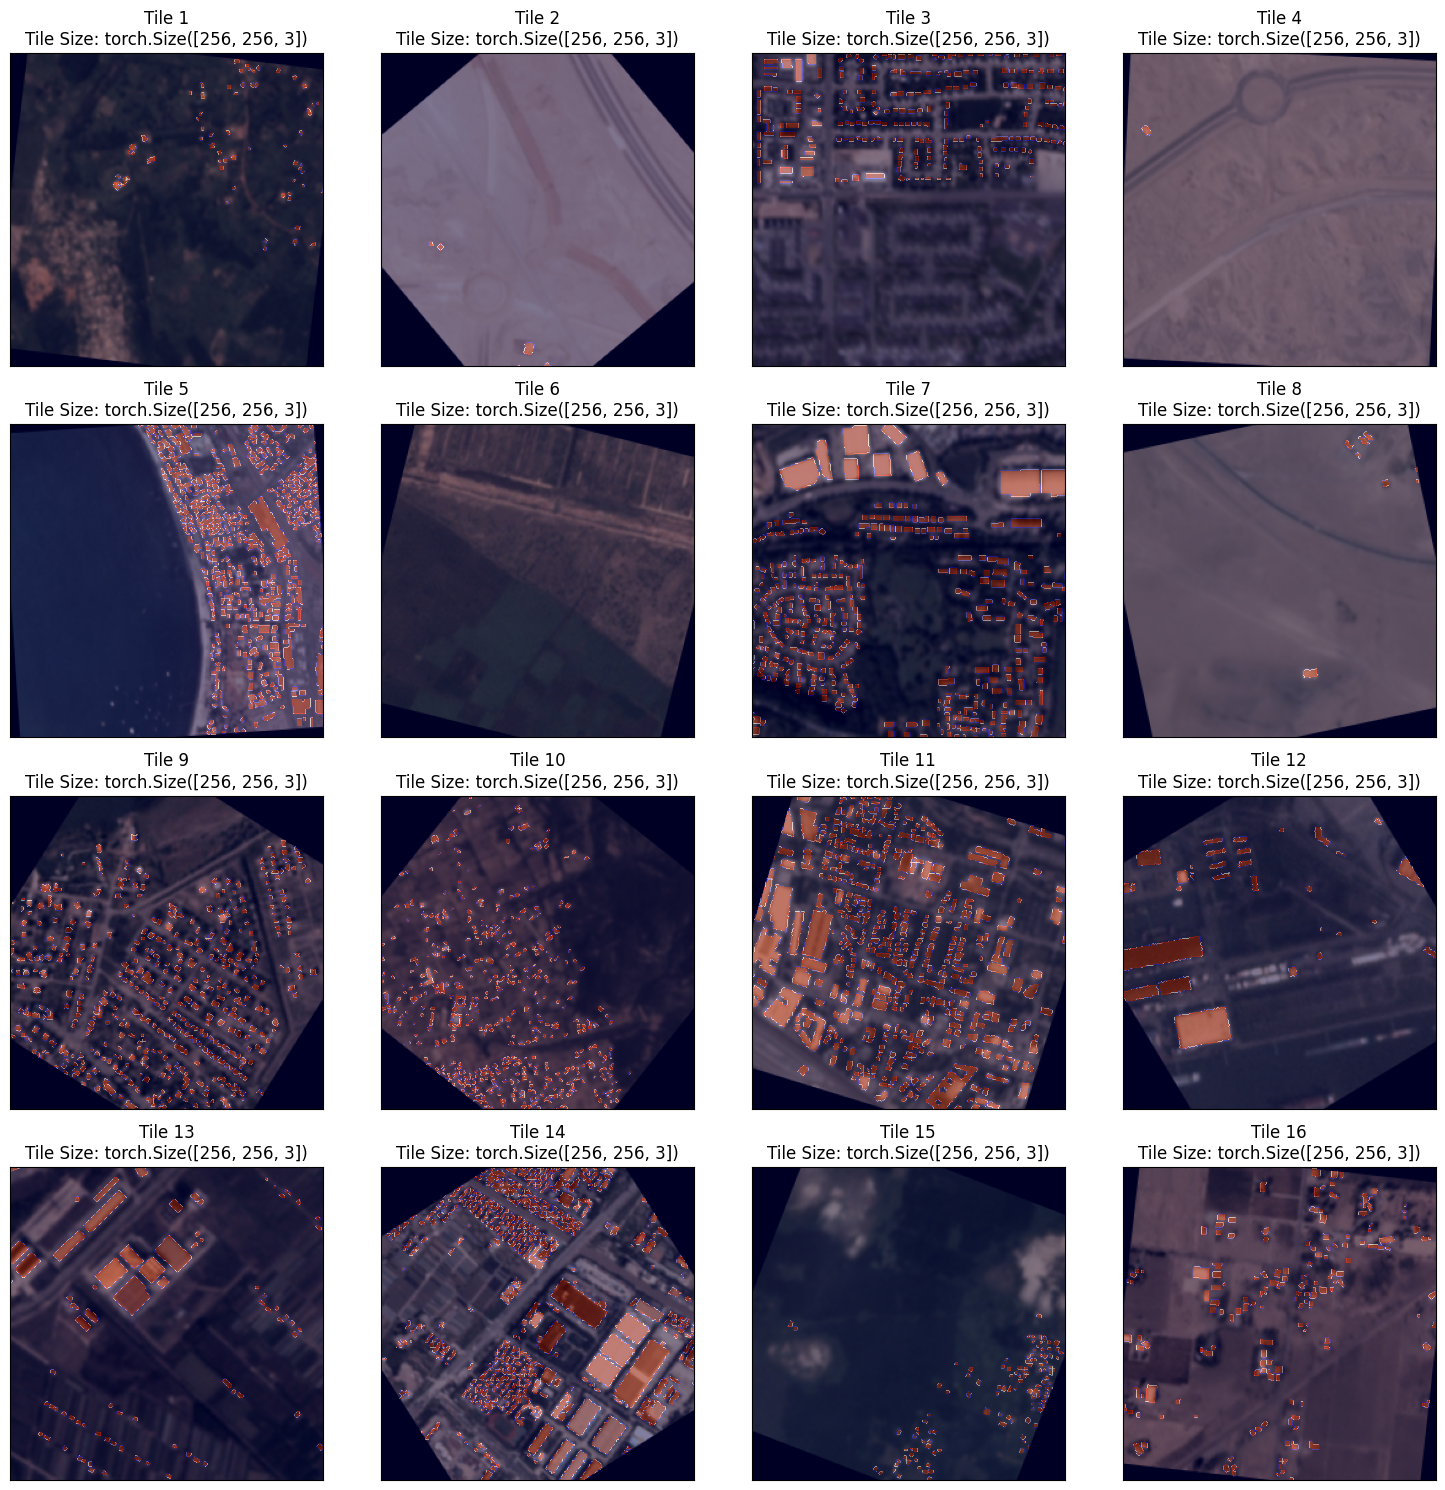

In [9]:
images, masks = next(iter(train_loader))
visualize_loaded_tiles(images, masks)

In [10]:
tile_size = 256
batch_size = 8

train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Blur(blur_limit=3, p=0.5),
    A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT)
    ],is_check_shapes = False)

device = torch.device("cuda" if torch.cuda.is_available else "cpu")
train_files, val_files = train_test_split(files, test_size=0.2, random_state=42, shuffle=True)

train_dataset = SpaceNet7(files=train_files, tile_size=tile_size, transforms_=train_transforms)
val_dataset = SpaceNet7(files=val_files, tile_size=tile_size)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

print(f'len train: {len(train_files)}')
print(f'len val: {len(val_files)}')

len train: 160
len val: 40


# MODEL BUILDING

In [11]:
# ENCODER = 'resnet50'
# ENCODER_WEIGHTS = 'imagenet'
# class_size = 1
# ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# # create segmentation model with pretrained encoder
# model = smp.Unet(
#     encoder_name=ENCODER, 
#     encoder_weights=ENCODER_WEIGHTS, 
#     classes=class_size, 
#     activation=ACTIVATION,
# )

# preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [12]:
def set_seed(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [13]:
class Config:
    train = True
    train_aug=True
    
    num_epochs = 30
    num_classes = 1
    batch_size = 16
    seed = 42
    
    encoder = 'resnet50'
    pretrained = True
    weights = 'imagenet'
    classes = 1
    activation = 'sigmoid'
    in_chans = 3
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    image_size = 256
    warmup = 0
    lr = 0.01

In [14]:
def dice_coef(y_true, y_pred, thr=0.5, epsilon=0.001):
    y_true = y_true.flatten()
    y_pred = (y_pred>thr).astype(np.float32).flatten()
    inter = (y_true*y_pred).sum()
    den = y_true.sum() + y_pred.sum()
    dice = ((2*inter+epsilon)/(den+epsilon))
    return dice

In [15]:
class UNet(nn.Module):
    def __init__(self, cfg):
        super(UNet, self).__init__()
        
        self.cfg = cfg
        self.training = True
        
        self.model = smp.Unet(
            encoder_name=cfg.encoder, 
            encoder_weights=cfg.weights, 
            decoder_use_batchnorm=True,
            classes=cfg.classes, 
            activation=cfg.activation,
        )
        
        self.loss_fn = smp.losses.DiceLoss(mode='binary')
    
    def forward(self, imgs, targets):
        x = imgs
        y = targets

        logits = self.model(x)
        
        if Config.image_size != 256:
            logits = F.interpolate(logits, size=(256, 256), mode='nearest-exact')
        
        loss = self.loss_fn(logits, y)
        
        return {"loss": loss, "logits": logits.sigmoid(), "logits_raw": logits, "target": y}

In [16]:
def train_step(model, dataloader, optimizer, device):
    
    model.train()
    
    train_losses = []
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    
    for step, (X, y) in pbar:
        
        X, y = X.to(device), y.to(device)
        torch.set_grad_enabled(True)
        
        output_dict = model(X, y)
        loss = output_dict["loss"]
        train_losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if scheduler is not None:
            scheduler.step()
    
    train_loss = np.sum(train_losses)
    
    return train_loss

In [17]:
def test_step(model, dataloader, device):
    
    model.eval()
    torch.set_grad_enabled(False)
    
    val_data = defaultdict(list)
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid')
    for step, (X, y) in pbar: 
        X, y = X.to(device), y.to(device)

        output = model(X, y)
        for key, val in output.items():
            val_data[key] += [output[key]]

    for key, val in output.items():
        value = val_data[key]
        if len(value[0].shape) == 0:
            val_data[key] = torch.stack(value)
        else:
            val_data[key] = torch.cat(value, dim=0).cpu().detach().numpy()
    
    val_losses = val_data["loss"].cpu().numpy()
    val_loss = np.sum(val_losses)
    
    val_dice = dice_coef(val_data['target'], val_data['logits'])
    
    return val_loss, val_dice

In [18]:
def train(model, train_dataloader, test_dataloader, optimizer, epochs, device):
    
    # Earlystopping
    patience = 8
    counter = 0
    best_loss = np.inf
    
    results = {'train_loss': [],
              'val_loss': [],
              'val_dice': []}
    
    for epoch in range(epochs):
        set_seed(Config.seed + epoch)
        print("EPOCH:", epoch)
        
        train_loss = train_step(model,
                              train_dataloader,
                              optimizer,
                              device)
        val_loss, val_dice = test_step(model,
                            test_dataloader,
                            device)
        
        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        
        print(f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f}')
        print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
        
        results['train_loss'].append(train_loss)
        results['val_loss'].append(val_loss)
        results['val_dice'].append(val_dice)
        
        if os.path.exists('/kaggle/working/checkpoints') == False:
            os.mkdir("/kaggle/working/checkpoints")
            
        PATH = f"/kaggle/working/checkpoints/last.pth"
        torch.save(model.state_dict(), PATH)
        
        if val_loss < best_loss:
            counter = 0
            best_loss = val_loss
            torch.save(model.state_dict(), "/kaggle/working/checkpoints/best.pth")
        else:
            counter += 1
            
        if counter >= patience:
            print("Earlystop!")
            break

    return results

In [19]:
def get_optimizer(lr, params):
    model_optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, params), 
            lr=lr,
            weight_decay=0)
    
    return model_optimizer

In [20]:
def get_scheduler(cfg, optimizer, total_steps):
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps= cfg.warmup * (total_steps // cfg.batch_size),
        num_training_steps= cfg.num_epochs * (total_steps // cfg.batch_size)
    )
    return scheduler

In [21]:
NUM_EPOCHS = Config.num_epochs
model = UNet(Config).to(Config.device)

total_steps = len(train_dataset)
optimizer = get_optimizer(lr=Config.lr, params=model.parameters())
scheduler = get_scheduler(Config, optimizer, total_steps)

from timeit import default_timer as timer
start_time = timer()

model_results = train(model, train_loader, val_loader, optimizer, NUM_EPOCHS, Config.device)

end_time = timer()

print(f'Total Training Time: {end_time-start_time:.3f} seconds')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 138MB/s]


EPOCH: 0


Train :   0%|          | 0/20 [00:00<?, ?it/s]

Valid:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8571 | Val Loss: 0.8188 | Val Dice: 0.1963
Learning rate: 0.009890738003669028
EPOCH: 1


Train :   0%|          | 0/20 [00:00<?, ?it/s]

Valid:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8419 | Val Loss: 0.8034 | Val Dice: 0.2203
Learning rate: 0.009567727288213004
EPOCH: 2


Train :   0%|          | 0/20 [00:00<?, ?it/s]

Valid:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8536 | Val Loss: 0.8108 | Val Dice: 0.2056
Learning rate: 0.009045084971874737
EPOCH: 3


Train :   0%|          | 0/20 [00:00<?, ?it/s]

Valid:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8100 | Val Loss: 0.8177 | Val Dice: 0.1810
Learning rate: 0.008345653031794291
EPOCH: 4


Train :   0%|          | 0/20 [00:00<?, ?it/s]

Valid:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.7946 | Val Loss: 0.7332 | Val Dice: 0.2823
Learning rate: 0.0075
EPOCH: 5


Train :   0%|          | 0/20 [00:00<?, ?it/s]

Valid:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8188 | Val Loss: 0.7594 | Val Dice: 0.2563
Learning rate: 0.006545084971874737
EPOCH: 6


Train :   0%|          | 0/20 [00:00<?, ?it/s]

Valid:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8243 | Val Loss: 0.6983 | Val Dice: 0.3168
Learning rate: 0.0055226423163382676
EPOCH: 7


Train :   0%|          | 0/20 [00:00<?, ?it/s]

Valid:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8345 | Val Loss: 0.7692 | Val Dice: 0.2426
Learning rate: 0.0044773576836617335
EPOCH: 8


Train :   0%|          | 0/20 [00:00<?, ?it/s]

Valid:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8136 | Val Loss: 0.7507 | Val Dice: 0.2610
Learning rate: 0.003454915028125263
EPOCH: 9


Train :   0%|          | 0/20 [00:00<?, ?it/s]

Valid:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8195 | Val Loss: 0.6508 | Val Dice: 0.3597
Learning rate: 0.0025000000000000014
EPOCH: 10


Train :   0%|          | 0/20 [00:00<?, ?it/s]

Valid:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8577 | Val Loss: 0.7130 | Val Dice: 0.3006
Learning rate: 0.0016543469682057106
EPOCH: 11


Train :   0%|          | 0/20 [00:00<?, ?it/s]

Valid:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8523 | Val Loss: 0.7256 | Val Dice: 0.2771
Learning rate: 0.0009549150281252633
EPOCH: 12


Train :   0%|          | 0/20 [00:00<?, ?it/s]

Valid:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8184 | Val Loss: 0.8193 | Val Dice: 0.1776
Learning rate: 0.0004322727117869951
EPOCH: 13


Train :   0%|          | 0/20 [00:00<?, ?it/s]

Valid:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8340 | Val Loss: 0.6962 | Val Dice: 0.3111
Learning rate: 0.00010926199633097155
EPOCH: 14


Train :   0%|          | 0/20 [00:00<?, ?it/s]

Valid:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8230 | Val Loss: 0.7894 | Val Dice: 0.2164
Learning rate: 0.0
EPOCH: 15


Train :   0%|          | 0/20 [00:00<?, ?it/s]

Valid:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8271 | Val Loss: 0.7107 | Val Dice: 0.2857
Learning rate: 0.00010926199633097155
EPOCH: 16


Train :   0%|          | 0/20 [00:00<?, ?it/s]

Valid:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8314 | Val Loss: 0.8584 | Val Dice: 0.1387
Learning rate: 0.00043227271178699456
EPOCH: 17


Train :   0%|          | 0/20 [00:00<?, ?it/s]

Valid:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8151 | Val Loss: 0.6886 | Val Dice: 0.3170
Learning rate: 0.0009549150281252622
Earlystop!
Total Training Time: 21234.272 seconds


In [22]:
# class_size = 1
# model = smp.Unet(
#     encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
#     in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#     classes=class_size,                      # model output channels (number of classes in your dataset)
# )

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# print(device)
# model.to(device)

In [23]:
# model.train()
# loss_fn = smp.losses.DiceLoss(mode="binary")
# for batch_i, batch in enumerate(train_loader):
#     x, y = batch[0].to(device), batch[1].to(device)
#   # Forward pass
#     outputs = model(x)
#   # Calculate loss
#     loss = loss_fn(outputs, y)
#     print(loss)
#     break

In [24]:
# def train(dataloader, model, loss_fn, optimizer, lr_scheduler):
#     size = len(dataloader.dataset) # number of samples
#     num_batches = len(dataloader) # batches per epoch
#     model.train() # to training mode.
#     epoch_loss = 0
#     epoch_iou_score = 0
#     for batch_i, batch in enumerate(dataloader):
#         x, y = batch[0].to(device), batch[1].to(device) # move data to GPU
#         optimizer.zero_grad()
#         pred = model(x)
#         loss = loss_fn(pred, y)

#         loss.backward() # backpropagation to compute gradients
#         optimizer.step() # update model params

#         epoch_loss += loss.item() # tensor -> python value
#         pred = pred.squeeze(dim=1)
#         pred = torch.sigmoid(pred)
#         y = y.round().long()
#         tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='binary', threshold=0.5)
#         iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
#         epoch_iou_score += iou_score
#         lr_scheduler.step()
#     # return avg loss of epoch, acc of epoch
#     return epoch_loss/num_batches, epoch_iou_score/num_batches

# def test(dataloader, model, loss_fn):
#     size = len(dataloader.dataset) # number of samples
#     num_batches = len(dataloader) # batches per epoch
#     model.eval() # model to test mode.
#     epoch_loss = 0
#     epoch_iou_score = 0
#     # No gradient for test data
#     with torch.no_grad():
#         for batch_i, batch in enumerate(dataloader):
#             x, y = batch[0].to(device), batch[1].to(device) # move data to GPU
#             # Compute prediction loss
#             pred = model(x)
#             loss = loss_fn(pred, y)
#             # write to logs
#             epoch_loss += loss.item()
#             pred = pred.squeeze(dim=1)
#             pred = torch.sigmoid(pred)
#             y = y.round().long()
#             tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='binary', threshold=0.5)
#             iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
#             epoch_iou_score += iou_score
          
#     return epoch_loss/num_batches, epoch_iou_score/num_batches

# MODEL TRAINING

In [25]:
# # EPOCHS = 50
# EPOCHS = 20

# logs = {
#     'train_loss': [], 'val_loss': [],
#     'train_iou_score': [], 'val_iou_score': [],
# }

# if os.path.exists('/kaggle/working/checkpoints') == False:
#     os.mkdir("/kaggle/working/checkpoints")

# loss_fn = smp.losses.DiceLoss(mode="binary")
# learning_rate = 0.001
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 200, gamma=0.1)

# # Earlystopping
# patience = 5
# counter = 0
# best_loss = np.inf

# model.to(device)
# for epoch in tqdm(range(EPOCHS)):
#     train_loss, train_iou_score = train(train_loader, model, loss_fn, optimizer, step_lr_scheduler)
#     val_loss, val_iou_score = test(val_loader, model, loss_fn)
#     logs['train_loss'].append(train_loss)
#     logs['val_loss'].append(val_loss)
#     logs['train_iou_score'].append(train_iou_score)
#     logs['val_iou_score'].append(val_iou_score)

#     print(f'EPOCH: {str(epoch+1).zfill(3)} \
#     train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f} \
#     train_iou_score: {train_iou_score:.3f}, val_iou_score: {val_iou_score:.3f} \
#     lr: {optimizer.param_groups[0]["lr"]}')
#     # On epoch end
#     torch.save(model.state_dict(), "/kaggle/working/checkpoints/last.pth")
#     # check improvement
#     if val_loss < best_loss:
#         counter = 0
#         best_loss = val_loss
#         torch.save(model.state_dict(), "/kaggle/working/checkpoints/best.pth")
#     else:
#         counter += 1
#     if counter >= patience:
#         print("Earlystop!")
#         break

# MODEL EVALUATION

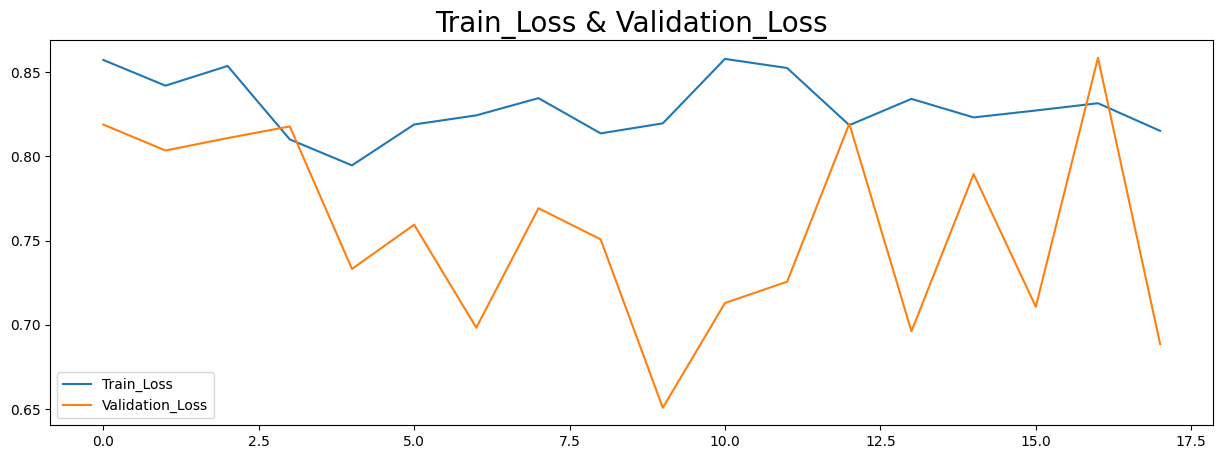

In [26]:
plt.figure(figsize=(15,5))
# plt.subplot(1,2,1)
plt.plot(model_results['train_loss'],label='Train_Loss')
plt.plot(model_results['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
# plt.subplot(1,2,2)
# plt.plot(logs['train_iou_score'],label='Train_Iou_Score')
# plt.plot(logs['val_iou_score'],label='Validation_Iou_Score')
# plt.title('Train_Iou_score & Validation_Iou_score',fontsize=20)
# plt.legend()